# **Adaptive Prediction Sets (APS)**

### The Problem of Uncertainty in Machine Learning Predictions


Traditional ML models do not provide information about **uncertainty or reliabilty**. But that is **crucial** in critical applications, that are in need of **guaranteed coverage**.

An example for such application would be an autuonomous driving application. It is not enough to predict "It is a pedestrian", the application has **to be confident** about something on the road being "a pedestrian, cyclist or a traffic sign", to prevent serious concequences.


### Core Idea: Conformal Prediction

While traditional ML models only provide point predictions, APS provide prediction sets. 

Traditional: Model predicts "class 3"

APS: Model predicts "{2, 3, 5}" with 90% confidence

### Marginal Coverage

Marginal coverage provides a statistical guarantee.

$$\mathbb{P}[Y_{n+1} \in \hat{C}_{n,\alpha}(X_{n+1})] \geq 1-\alpha$$

Where: 
- $\mathbb{P}[\cdot]$: Probability operator
- $Y_{n+1}$: Unknown true label we want to predict
- $\hat{\mathcal{C}}_{n,\alpha}(\cdot)$: prediction set function that maps features
- $X_{n+1}$: Observed features of test point
- $1-\alpha$: Target probability of coverage

Let's look at a simple coverage test, where $\alpha=0.1$.

In [171]:
test_images = 10
alpha = 0.1
target_coverage = 1 - alpha

results = [1, 1, 1, 1, 1, 1, 1, 0, 1, 1]  # 9 out of 10 correct

coverage = sum(results) / len(results)

print(f"Number of test images: {test_images}")
print(f"Target coverage: {target_coverage} (90%)")
print(f"Actual coverage: {coverage} ({coverage * 100}%)")
print(f"Coverage >= Target coverage: {coverage >= target_coverage}")
print(f"Calculation: {sum(results)} / {len(results)} = {coverage}")

Number of test images: 10
Target coverage: 0.9 (90%)
Actual coverage: 0.9 (90.0%)
Coverage >= Target coverage: True
Calculation: 9 / 10 = 0.9


### The APS Algorithm

Provides the Conformity Score:
$$ E(x,y,u;\hat{\pi}) = \min\{\tau \in [0,1] : y \in \mathcal{S}(x,u;\hat{\pi},\tau)\} $$

The conformity score measures the **minimum probability threshold** at which the true label would be included in the prediction set, quantifying how **"surprised"** the model is by the correct answer.

Following: A Simple APS Conformity Score implemented:

In [172]:
from typing import Any, Self

import numpy as np


def aps_conformity_score(_self: None, probabilities: np.ndarray, true_labels: np.ndarray) -> np.ndarray:
    """E(x,y,u;π̂) = min{τ ∈ [0,1] : y ∈ S(x,u;π̂,τ)}.

    Finds the minimum threshold τ at which the true class
    is included in the prediction set.
    """
    conformity_scores = []

    for true_label, probs in zip(true_labels, probabilities, strict=False):
        # descending
        sorted_indices = np.argsort(probs)[::-1]
        sorted_probs = probs[sorted_indices]

        cumulative_probs = np.cumsum(sorted_probs)

        true_class_pos = np.where(sorted_indices == true_label)[0][0]

        # score is cumulative prob up to the true class
        aps_score = cumulative_probs[true_class_pos]
        conformity_scores.append(aps_score)

    return np.array(conformity_scores)

Where inputs are probabilitites(model's predicted probabilities), true_labels.

For each sample, sort classes by probability and find the **cumulative probability at whih the true class is included**.

Low conformity score means the model is "surprised" by the true label.

Mathemathical Interpretation: The minimum probability threshold τ where the true class y would be included in the prediction set S(x,τ).

### APS implemented on Iris Dataset

1. Whats is the Iris Dataset? 
The Iris Dataset is a classical benchmark dataset, which contains 150 samples of the 3 different species (50 samples per species) of the iris flower. It is an ideal dataset to test and teach such algorithms through examples.

Heres an implementation of Iris and APS implemented:


In [173]:
from matplotlib.axes import Axes
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


class APSIrisImplementation:
    """Complete APS Implementation."""

    def __init__(self: Any, significance_level: float = 0.1) -> None:
        """Initializes APS system with given significance level."""
        self.significance_level = significance_level
        self.model = None
        self.quantile = None
        self.calibration_scores = None

    def load_prepare_data(self) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """Load and split the Iris dataset."""
        iris = load_iris()
        x, y = iris.data, iris.target
        feature_names = iris.feature_names
        target_names = iris.target_names

        # split inot train, calib, and test set
        x_temp, x_test, y_temp, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)
        x_train, x_calib, y_train, y_calib = train_test_split(
            x_temp,
            y_temp,
            test_size=0.25,
            random_state=42,
            stratify=y_temp,
        )

        return x_train, x_calib, x_test, y_train, y_calib, y_test, feature_names, target_names

    def train_model(self, x_train: np.ndarray, y_train: np.ndarray) -> RandomForestClassifier:
        """Train base classifier."""
        self.model = RandomForestClassifier(n_estimators=100, random_state=42)
        self.model.fit(x_train, y_train)
        return self.model

    def aps_conformity_score(self: Any, probabilities: np.ndarray, true_labels: np.ndarray) -> np.ndarray:
        """E(x,y,u;π̂) = min{τ ∈ [0,1] : y ∈ S(x,u;π̂,τ)}.

        Finds the minimum threshold τ at which the true class
        is included in the prediction set.
        """
        conformity_scores = []

        for true_label, probs in zip(true_labels, probabilities, strict=False):
            # descending
            sorted_indices = np.argsort(probs)[::-1]
            sorted_probs = probs[sorted_indices]

            cumulative_probs = np.cumsum(sorted_probs)

            true_class_pos = np.where(sorted_indices == true_label)[0][0]

            # score is cumulative prob up to the true class
            aps_score = cumulative_probs[true_class_pos]
            conformity_scores.append(aps_score)

        return np.array(conformity_scores)

    def calculate_prediction_sets(self, probabilities: np.ndarray, tau: float) -> list[list[int]]:
        """Calculates prediction sets for for given threshold tau."""
        prediction_sets = []

        for probs in probabilities:
            sorted_indices = np.argsort(probs)[::-1]
            sorted_probs = probs[sorted_indices]
            cumulative_probs = np.cumsum(sorted_probs)

            prediction_set = []
            for i, (class_idx, cum_prob) in enumerate(zip(sorted_indices, cumulative_probs, strict=False)):
                if cum_prob <= tau or i == 0:
                    prediction_set.append(class_idx)
                else:
                    break

            prediction_sets.append(prediction_set)

        return prediction_sets

    def fit_aps(self, x_train: np.ndarray, y_train: np.ndarray, x_calib: np.ndarray, y_calib: np.ndarray) -> Self:
        """Trains model and calibrates APS."""
        # train model
        self.train_model(x_train, y_train)
        # calculate confirmity scoer on data
        calib_probs = self.model.predict_proba(x_calib)
        self.calibration_scores = self.aps_conformity_score(calib_probs, y_calib)

        # calculate quantile for set
        self.quantile = np.quantile(self.calibration_scores, self.significance_level)

        print("APS Calibration Complete:")
        print(f"  Significance level (a): {self.significance_level}")
        print(f"  Calibration quantile: {self.quantile:.3f}")
        print(f"  Target coverage: {1 - self.significance_level:.1%}")

        return self

    def predict_with_aps(self, x: np.ndarray) -> tuple[np.ndarray, list[list[int]], np.ndarray]:
        """Makes predictions with APS sets."""
        probabilities = self.model.predict_proba(x)
        point_predictions = self.model.predict(x)
        prediction_sets = self.calculate_prediction_sets(probabilities, self.quantile)
        aps_scores = self.aps_conformity_score(probabilities, point_predictions)

        return point_predictions, prediction_sets, aps_scores

    def evaluate_aps(self, x_test: np.ndarray, y_test: np.ndarray) -> dict[str, float]:
        """Evaluates APS performance."""
        point_preds, prediction_sets, aps_scores = self.predict_with_aps(x_test)

        # calculate metrics
        coverage = np.mean(
            [true_label in pred_set for true_label, pred_set in zip(y_test, prediction_sets, strict=False)],
        )
        avg_set_size = np.mean([len(pred_set) for pred_set in prediction_sets])
        accuracy = accuracy_score(y_test, point_preds)

        # calculate set size distribution
        set_sizes = [len(pred_set) for pred_set in prediction_sets]
        single_pred_rate = np.mean(np.array(set_sizes) == 1)
        multi_pred_rate = np.mean(np.array(set_sizes) > 1)

        return {
            "coverage": coverage,
            "average_set_size": avg_set_size,
            "point_accuracy": accuracy,
            "empirical_alpha": 1 - coverage,
            "single_prediction_rate": single_pred_rate,
            "multi_prediction_rate": multi_pred_rate,
            "aps_scores": aps_scores,
            "set_sizes": set_sizes,
        }


def plot_conformity_scores(_ax1: Axes, results: dict[str, Any], aps_system: APSIrisImplementation) -> None:
    """Plot APS conformity score distribution."""
    # create aps score distribution
    _ax1 = plt.subplot(2, 2, 1)
    plt.hist(results["aps_scores"], bins=20, alpha=0.7, color="skyblue", edgecolor="black")
    plt.axvline(
        x=aps_system.quantile,
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Calibration Quantile (τ={aps_system.quantile:.3f})",
    )
    plt.xlabel("APS Conformity Score")
    plt.ylabel("Frequency")
    plt.title('Distribution of APS Conformity Scores\n(Lower = More "Surprised")')
    plt.legend()
    plt.grid(True, alpha=0.0)


def plot_prediction_sets(_ax2: Axes, results: dict[str, Any]) -> None:
    """Plot distribution of prediction set sizes."""
    # prediction Set Sizes
    _ax2 = plt.subplot(2, 2, 2)
    set_size_counts = pd.Series(results["set_sizes"]).value_counts().sort_index()
    plt.bar(set_size_counts.index, set_size_counts.values, color="lightgreen", alpha=0.7, edgecolor="black")
    plt.xlabel("Prediction Set Size")
    plt.ylabel("Number of Samples")
    plt.title("Distribution of Prediction Set Sizes")
    for i, v in enumerate(set_size_counts.values):
        plt.text(set_size_counts.index[i], v + 0.5, str(v), ha="center")
    plt.grid(True, alpha=0.2)


def plot_coverage(
    _ax3: Axes,
    aps_system: APSIrisImplementation,
    y_test: np.ndarray,
    prediction_sets: list[list[int]],
    target_names: list[str],
) -> None:
    # coverage by Class
    _ax3 = plt.subplot(2, 2, 3)
    coverage_by_class = []
    for class_label in range(len(target_names)):
        class_mask = y_test == class_label
        class_coverage = np.mean(
            [
                true_label in pred_set
                for true_label, pred_set in zip(y_test[class_mask], np.array(prediction_sets)[class_mask], strict=False)
            ],
        )
        coverage_by_class.append(class_coverage)
    _bars = plt.bar(range(len(target_names)), coverage_by_class, color=["lightcoral", "lightgreen", "lightblue"])
    plt.axhline(
        y=1 - aps_system.significance_level,
        color="red",
        linestyle="--",
        label=f"Target Coverage ({1 - aps_system.significance_level:.1%})",
    )
    plt.xlabel("Iris Species")
    plt.ylabel("Coverage Rate")
    plt.title("Coverage Rate by Class")
    plt.xticks(range(len(target_names)), target_names, rotation=45)
    plt.legend()
    for i, v in enumerate(coverage_by_class):
        plt.text(i, v + 0.02, f"{v:.3f}", ha="center")
    plt.grid(True, alpha=0.2)


def plot_feature_space_visualization(
    _ax4: Axes,
    x_test: np.ndarray,
    y_test: np.ndarray,
    prediction_sets: list[list[int]],
    _aps_scores: np.ndarray,
    _feature_names: list[str],
) -> None:
    # feature Space Visualization (First 2 features)
    _ax4 = plt.subplot(2, 2, 4)
    plt.subplots_adjust(top=0.9, hspace=0.4, wspace=0.3, right=0.7)
    colors = ["red", "green", "blue"]
    set_size_markers = ["o", "s", "D"]  # circle, square, diamond

    for i, (true_label, pred_set, _aps_score) in enumerate(zip(y_test, prediction_sets, _aps_scores, strict=False)):
        marker_size = 100 if len(pred_set) == 1 else 150
        marker_alpha = 0.7 if len(pred_set) == 1 else 0.9

        if true_label in pred_set:
            # Correct prediction - green border
            facecolor = colors[true_label]
            edgecolor = "green"
            linewidth = 2
        else:
            # Incorrect prediction - red border
            facecolor = colors[true_label]
            edgecolor = "red"
            linewidth = 3

        plt.scatter(
            x_test[i, 0],
            x_test[i, 1],
            c=facecolor,
            marker=set_size_markers[len(pred_set) - 1],
            s=marker_size,
            alpha=marker_alpha,
            edgecolor=edgecolor,
            linewidth=linewidth,
        )


def create_visualisation(
    aps_system: APSIrisImplementation,
    x_test: np.ndarray,
    y_test: np.ndarray,
    feature_names: list[str],
    target_names: list[str],
    results: dict[str, Any],
) -> None:
    """Comprehensive visualisation of APS results."""
    # get prediction and detail
    point_preds, prediction_sets, _aps_scores = aps_system.predict_with_aps(x_test)
    _probabilities = aps_system.model.predict_proba(x_test)

    # create fig
    _fig = plt.figure(figsize=(15, 12))

    # create aps score distribution
    _ax1 = plt.subplot(2, 2, 1)
    plot_conformity_scores(_ax1, results, aps_system)

    # prediction Set Sizes
    _ax2 = plt.subplot(2, 2, 2)
    plot_prediction_sets(_ax2, results)

    # coverage by Class
    _ax3 = plt.subplot(2, 2, 3)
    plot_coverage(_ax3, aps_system, y_test, prediction_sets, target_names)

    # feature Space Visualization (First 2 features)
    _ax4 = plt.subplot(2, 2, 4)
    plot_feature_space_visualization(_ax4, x_test, y_test, prediction_sets, _aps_scores, feature_names)

    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.title("Feature Space with APS Prediction Sets\n(Marker: ○=1 class, □=2 classes, ◊=3 classes)")

What we just did with this code is a visualization of the calculated values. 
<br> The first diagram, the Distribution of APS Conformity Scores, shows us the cumulative probabilities used for calibration. The lower our score is the more **´surprised´** our machine is about the outcome of the **true** class.
<br> The second illustration demonstrates the distribution of the prediction set sizes. In general it is good to have more data for the tests than the calibration. However with a small set like this it is not entirely possible to have less than 30 because our calibration Quantil (τ) will not be stable which leads to a statistacally unreliable statement. A uniformity (here: 30) across the classes is often necessary when balancing the 90% coverage guarantee against a small calibration set.
<br> The third figure shows us the coverage rate of each class. Our target coverage rate is 90% which every species (classes) reaches or even exceeds. This also enforces to us that the coverage is sufficient and guaranteed.
<br> Our last graphic, Feature Spaces, visualizes the empirical coverage. The color and border of each point indicate if the true class was successfully covered (green border) or missed (red border). The marker shape reflects the model's uncertainty, showing whether one, two, or three classes were included in the prediction set.

=== APS Implementation on Iris Dataset ===

Dataset Information:
  Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
  Classes: [np.str_('setosa'), np.str_('versicolor'), np.str_('virginica')]
  Training samples: 90
  Calibration samples: 30
  Test samples: 30
APS Calibration Complete:
  Significance level (a): 0.1
  Calibration quantile: 0.898
  Target coverage: 90.0%

APS Evaluation Results:
  Coverage rate: 0.933
  Average set size: 1.00
  Point prediction accuracy: 0.933


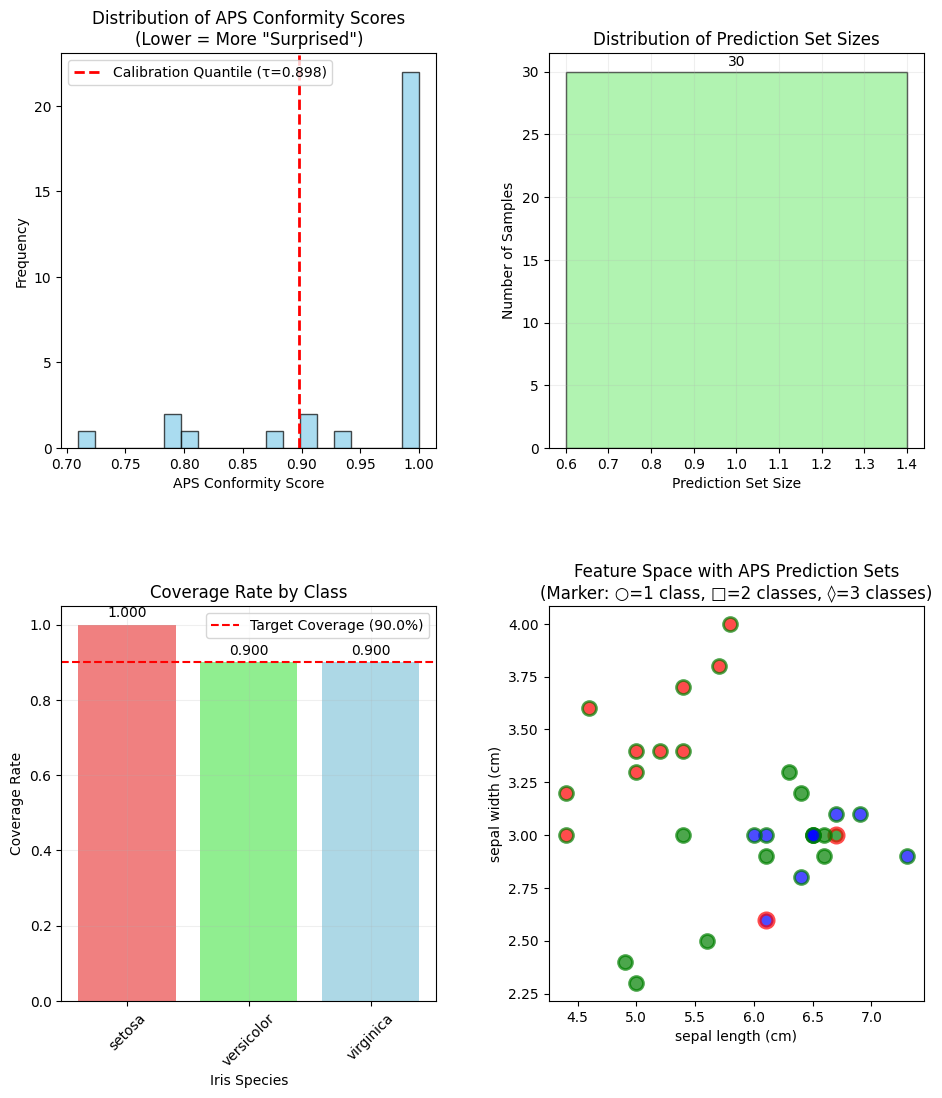

In [174]:
from typing import Any


def main() -> tuple[APSIrisImplementation, dict[str, float]]:
    """Main function to run APS on Iris dataset."""
    print("=== APS Implementation on Iris Dataset ===\n")

    # initialize APS system
    aps_system = APSIrisImplementation(significance_level=0.1)

    # load data
    x_train, x_calib, x_test, y_train, y_calib, y_test, feature_names, target_names = aps_system.load_prepare_data()

    print("Dataset Information:")
    print(f"  Features: {feature_names}")
    print(f"  Classes: {list(target_names)}")
    print(f"  Training samples: {x_train.shape[0]}")
    print(f"  Calibration samples: {x_calib.shape[0]}")
    print(f"  Test samples: {x_test.shape[0]}")

    # train and calibrate APS
    aps_system.fit_aps(x_train, y_train, x_calib, y_calib)

    # evaluate APS
    results = aps_system.evaluate_aps(x_test, y_test)

    print("\nAPS Evaluation Results:")
    print(f"  Coverage rate: {results['coverage']:.3f}")
    print(f"  Average set size: {results['average_set_size']:.2f}")
    print(f"  Point prediction accuracy: {results['point_accuracy']:.3f}")

    # create visualization
    create_visualisation(aps_system, x_test, y_test, feature_names, target_names, results)

    return aps_system, results


if __name__ == "__main__":
    aps_system, results = main()